<a href="https://colab.research.google.com/github/aidanjmaldonado/penny-stock-lstm/blob/main/penny_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import sqlite3
import requests
import sys
import pytz








In [2]:
# Download database from github repository
historical_url = "https://raw.githubusercontent.com/CSE-115-UCSC/penny-stock-lstm/main/historicaldata.db"
scrape_request = requests.get(historical_url)

try:
  # Contingent on request status
  scrape_request = requests.get(historical_url)
  scrape_request.raise_for_status()

  # Create local database from pull, name 'historicaldata.db'
  with open("historical.db", "wb") as db_file:
    db_file.write(scrape_request.content)

  print("Request to download database succeeded")


except:
  # Report failed request status
  sys.stderr.write("Request to download database failed")

Request to download database succeeded


In [3]:
# Connect to SQlite database
try:
  db = 'historical.db'
  sqliteConnection = sqlite3.connect(db)
  cursor = sqliteConnection.cursor()
  print(f'SQlite connected with {db}')

except:
  sys.stderr.write("Failed to connect to database")

SQlite connected with historical.db


In [4]:
# Gather User Input for Query
# ticker = input("Enter ticker symbol: ")
ticker = "IAG"

In [5]:
# Query {ticker(s)} from Database
try:
  query = f"SELECT * FROM all_historical;"
  cursor.execute(query)
  if cursor.fetchone() is None:
    raise Exception("No results")
  print(f"Success querying {ticker}")

except:
  sys.stderr.write(f"Failed to select {ticker}")

Success querying IAG


In [6]:
# Turn SQlite Database into Pandas Dataframe
data = pd.read_sql_query(query, sqliteConnection)
print(data.shape)

# Features
features = np.array(data.columns)
print(features)

# Display Head
data.head()

(549609, 10)
['id' 'ticker' 'volume' 'volume_weighted_average' 'open' 'close' 'high'
 'low' 'time' 'number_of_trades']


,id,ticker,volume,volume_weighted_average,open,close,high,low,time,number_of_trades
0,1,ACHR,269.0,3.0307,3.0301,3.030,3.0301,3.0300,1657643400000,4
1,2,ACHR,2037.0,3.0362,3.0400,3.040,3.0400,3.0350,1657643700000,35
2,3,ACHR,796.0,3.0364,3.0400,3.035,3.0400,3.0350,1657644000000,17
3,4,ACHR,1795.0,3.0356,3.0350,3.035,3.0400,3.0350,1657644300000,19
4,5,ACHR,10397.0,3.0286,3.0350,3.025,3.0350,3.0212,1657644600000,87


In [7]:
# Using the column 'time' (millisecond) add a new column 'dates' with datetime

dates = pd.to_datetime(data['time'], unit='ms')
# Transform the line above into a for loop
# dates = []
# for i, time in enumerate(data['time']):
#   #print the ith ticker
#   if (i > 450000):
#     print(data['ticker'][i])
#   dates.append(pd.to_datetime(time, unit='ms'))

# Convert to PST
dates = dates.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
# If you want to remove the timezone information and keep it as naive datetime in PST
dates = dates.dt.tz_localize(None)

In [8]:
data.shape

(549609, 10)

In [16]:
features = data[['volume', 'volume_weighted_average', 'open', 'close', 'high', 'low']].values


In [20]:
# Select features to use
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

def create_sequences(data, sequence_length, prediction_length):
    xs, ys = [], []
    index = 0
    count = 0
    while index < len(data) - sequence_length - prediction_length + 1:
        # Check if sequence is within a single day
        if dates[index].date() == dates[index + sequence_length].date():
            print("We got a sequence from", dates[index], "to", dates[index + sequence_length])
            xs.append(data[index:index + sequence_length])
            ys.append(data[index + sequence_length:index + sequence_length + prediction_length, 3])
            index += sequence_length
            count += 1
        else:  # Move index to the start of the next day
            newindex = index
            while dates[newindex].date() == dates[newindex + 1].date():
                newindex += 1
            newindex += 1
            index = newindex
    print("Valid days:", count)
    return np.array(xs), np.array(ys)

# One day sequence lenght
sequence_length = 78
prediction_length = 78
x, y = create_sequences(scaled_features, sequence_length, prediction_length)

train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Split data into train and test sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, x_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(prediction_length))

model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
model.evaluate(x_test, y_test)

We got a sequence from 2023-07-31 09:30:00 to 2023-07-31 16:00:00
We got a sequence from 2024-02-26 09:30:00 to 2024-02-26 16:00:00
We got a sequence from 2023-02-06 09:30:00 to 2023-02-06 16:00:00
We got a sequence from 2023-02-07 09:30:00 to 2023-02-07 16:00:00
We got a sequence from 2023-02-08 09:30:00 to 2023-02-08 16:00:00
We got a sequence from 2023-02-09 09:30:00 to 2023-02-09 16:00:00
We got a sequence from 2023-02-10 09:30:00 to 2023-02-10 16:00:00
We got a sequence from 2023-02-14 09:30:00 to 2023-02-14 16:00:00
We got a sequence from 2023-02-15 09:30:00 to 2023-02-15 16:00:00
We got a sequence from 2023-02-24 09:30:00 to 2023-02-24 16:00:00
We got a sequence from 2023-03-02 09:30:00 to 2023-03-02 16:00:00
We got a sequence from 2023-03-03 09:30:00 to 2023-03-03 16:00:00
We got a sequence from 2023-03-07 09:30:00 to 2023-03-07 16:00:00
We got a sequence from 2023-03-08 09:30:00 to 2023-03-08 16:00:00
We got a sequence from 2023-03-31 09:30:00 to 2023-03-31 16:00:00
We got a s

KeyboardInterrupt: 

In [11]:
# Create Prediction Stock dataset

try:
  query = f"SELECT * FROM EVGN_Predict;"
  cursor.execute(query)
  if cursor.fetchone() is None:
    raise Exception("No results")
  print(f"Success querying EVGN_Predict")
except:
  sys.stderr.write(f"Failed to select EVGN_Predict")

# Turn SQlite Database into Pandas Dataframe
predict_data_whole = pd.read_sql_query(query, sqliteConnection)

# Features
features = np.array(predict_data_whole.columns)

# Display Head
predict_data_whole.head()

# Split into known vs unknown, where unknown is the last 78 entries
split_index_whole = len(predict_data_whole) - 78
known_data_whole = predict_data_whole.iloc[:-78]
unknown_data_whole = predict_data_whole.iloc[-78:]



Success querying EVGN_Predict


In [12]:
# Predict stock sequence for real-time stock

# Select the 6 features that were used during training
features_to_use = ['volume', 'volume_weighted_average', 'open', 'close', 'high', 'low']  # replace with actual feature names

# Limit to these features
known_data_whole = known_data_whole[features_to_use]
unknown_data_whole = unknown_data_whole[features_to_use]

# Limit our context to only the most recent day
known_data_limited = known_data_whole[-78:]

# Convert limited data to nparray for reshaping
known_data_limited = known_data_limited.values

# Reshape to match the input shape expected by the model: (1, timesteps, features)
latest_sequence = known_data_limited.reshape(1, known_data_limited.shape[0], known_data_limited.shape[1])

print(latest_sequence.shape)

# Now you can make predictions
predicted_stock_sequence = model.predict(latest_sequence)

# Flatten the predicted sequence if needed
predicted_stock_sequence = predicted_stock_sequence.flatten()


(1, 78, 6)
1/1 [==============================] - 2s 2s/step


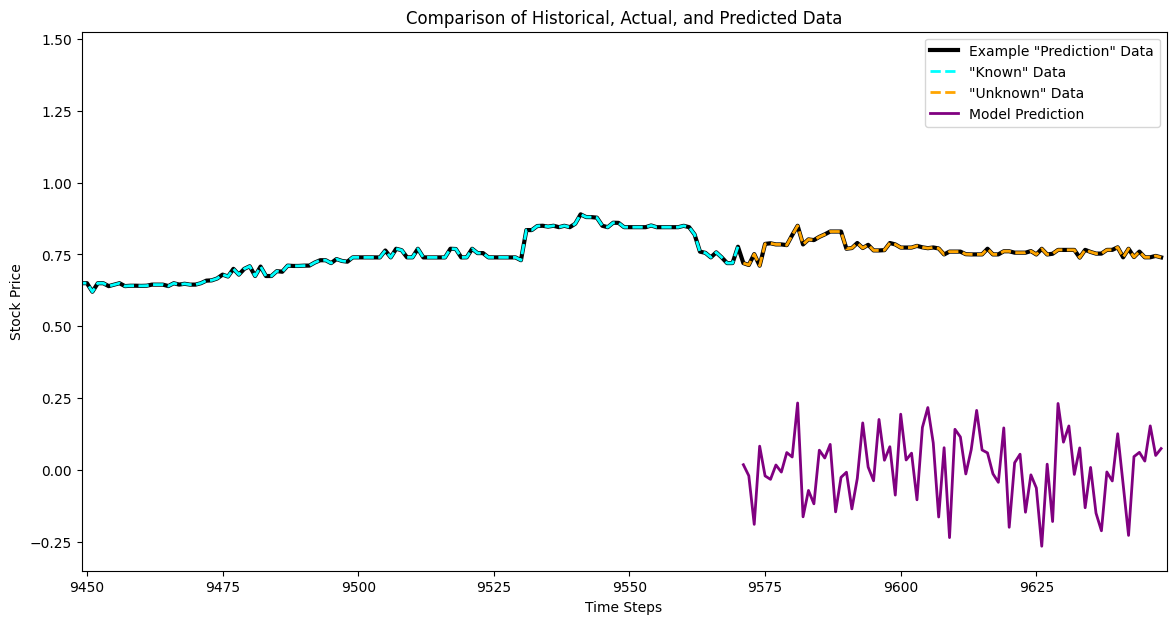

In [13]:
# Plot known in red and unkown in blue
import matplotlib.pyplot as plt

# Create the combined index for plotting
combined_index = np.arange(len(predict_data_whole))

# Create
plt.figure(figsize=(14, 7))

# Plot
plt.plot(combined_index, predict_data_whole['close'], label='Example "Prediction" Data', color='black', linewidth=3.0)
plt.plot(combined_index[:split_index_whole], known_data_whole['close'], label='"Known" Data', color='cyan', linewidth=2.0, linestyle="--")
plt.plot(combined_index[split_index_whole:], unknown_data_whole['close'], label='"Unknown" Data', color='orange', linewidth=2.0, linestyle="--")
plt.plot(combined_index[split_index_whole:], predicted_stock_sequence, label='Model Prediction', color='purple', linewidth=2.0, linestyle="-")

# Format
plt.title('Comparison of Historical, Actual, and Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()

# Adjust y-axis limits based on the data range
# plt.ylim(predict_data_whole.iloc[-200:]['close'].min() - 0.2, predict_data_whole.iloc[-200:]['close'].max() + 0.2)
plt.xlim(len(predict_data_whole) - 200, len(predict_data_whole))  # Crop view to just the very end

# Set y-tick locations with a step of 0.05
# yticks = np.arange(min(predict_data_whole['close']) // 0.05 * 0.05, (max(predict_data_whole['close']) // 0.05 + 1) * 0.05, 0.05)
# plt.yticks(yticks)

plt.show()


In [14]:
# #predict tomorrow's price sequence

# #Assuming 'x_test' contains the latest data points and 'model' is your trained model

# # Prepare the latest sequence from x_test (the last available or most recent sequence)
# latest_sequence = x_test[-1].reshape(1, x_test.shape[1], x_test.shape[2])


# # Predict tomorrow's stock price for each 5 minute interval
# predicted_stock_price = model.predict(latest_sequence)

# # Print the predicted stock price
# #print("Predicted stock price for tomorrow:", predicted_stock_price)

# #graph the historical data concatenated with the predicted data
# # Flatten the 3D data into 2D
# print(y_test.shape)
# actual = [x[0] for x in y_test]

# predicted = predicted_stock_price.reshape(-1)
# # Assuming y_train and y_test are already loaded and are in the correct shape
# historical_data = y_train.reshape(-1)[-100:]  # Last 100 points of training data for some context
# full_actual = np.concatenate([historical_data, actual])  # Concatenate historical data with actual test data

# # Create an index for predicted values to align them correctly on the x-axis
# predicted_index = np.arange(len(historical_data), len(historical_data) + len(predicted)) + len(actual)
# print(predicted_index)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(14, 7))
# plt.plot(full_actual, label='Actual Data', color='blue')
# plt.plot(predicted_index, predicted, label='Predicted Data', color='orange')
# plt.title('Comparison of Historical, Actual, and Predicted Data')
# plt.xlabel('Time Steps')
# plt.xlim(len(full_actual) - 200, len(full_actual) + 100)
# plt.ylabel('Stock Price')
# plt.legend()
# plt.show()
# print("hai!", full_actual.shape, "ho", predicted_index.shape)




